## Predicción de series temporales en Python

Para explicar cómo podemos hacer predicción sobre series temporales, utilizaremos un famoso conjunto de datos sobre la evolución del número de pasajeros en una famosa aerolínea americana desde 1949 a 1960.

### Paso 1. Lectura del conjunto de datos

In [1]:
import seaborn as sns

total_data = sns.load_dataset("flights")
total_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


El conjunto de datos en crudo nos serviría para realizar un proceso de Machine Learning usual como los que hemos visto en pasados módulos. En esta ocasión, necesitamos aplicar una transformación del mismo para generar una serie temporal con dos dimensiones: la temporal y la del dato que queremos analizar y predecir. En este caso, la dimensión temporal estará compuesta por el mes (`month`) y el año (`year`) y el dato que observaremos a lo largo del tiempo será el número de pasajeros (`passengers`).

In [2]:
import pandas as pd

total_data["month"] = pd.to_datetime(total_data.month, format = "%b").dt.month
total_data["date"] = pd.to_datetime(total_data[["year", "month"]].assign(day = 1))
total_data = total_data.set_index("date")
ts = total_data["passengers"]
ts.head()

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: passengers, dtype: int64

A continuación visualizaremos la serie temporal para llevar a cabo un análisis visual de la misma:

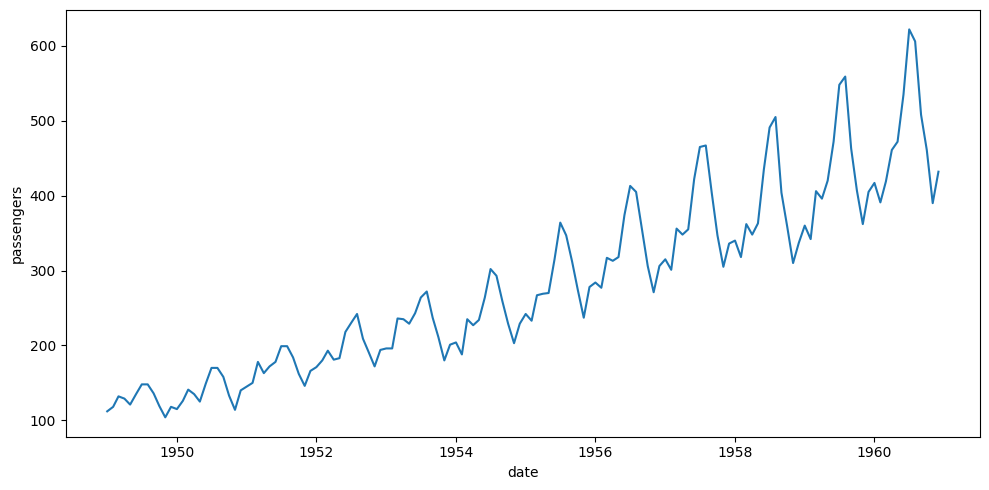

In [3]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

### Paso 2. Análisis de una serie temporal

Para analizar una serie temporal, como vimos en la teoría, debemos estudiar varios parámetros:

- **Tendencia**: Se aprecia una tendencia ascendente, lo que indica que el número de pasajeros ha aumentado a lo largo del tiempo. Esto puede deberse a varios factores: crecimiento de la industria aeronáutica y dotación de más recursos para movilizar pasajeros, reducción de precios, un mayor interés por los viajes aéreos, etcétera.
- **Estacionalidad**: Se observa cierta estacionalidad en los datos, con ciertos meses que consistentemente tienen más vuelos que otros. Esto podría deberse a la demanda estacional (más personas volando durante las vacaciones, por ejemplo).
- **Variabilidad**: Se observan ciertos puntos de variabilidad en la serie temporal, sobre todo entre los periodos de aumento y disminución en la demanda.
- **Puntos atípicos** (*Outliers*): Estudiando la tendencia y la estacionalidad de la serie temporal, no se aprecian outliers en la serie temporal.
- **Puntos de inflexión**: Dependiendo del año, el aumento en el número de pasajeros no es regular y a veces se producen variaciones en la pendiente; estos son, puntos de inflexión.

A través de un análisis visual podríamos ser capaces de estimar estas métricas a ojo, pero siempre es mejor orientar el análisis a los datos matemáticos. Para la labor de realizar predicciones sobre series temporales y analizarlas, nos apoyaremos en la librería `statsmodels`:

#### Descomposición de la serie

La descomposición de una serie temporal es un proceso estadístico que separa de una serie de tiempo en varios elementos diferenciados. Cada uno de estos componentes representa una parte de la estructura subyacente de la serie temporal. La descomposición de una serie de tiempo puede ser muy útil para entender mejor los datos y tomar decisiones informadas al construir modelos de pronóstico.

Utilizamos la función `seasonal_decompose` de la biblioteca `statsmodels` para descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuos.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 12)
decomposition

#### Análisis de la tendencia

La tendencia se refiere a la dirección general en la que se mueven los datos. Para acceder a su información recurrimos al componente `trend` del resultado `decomposition`.

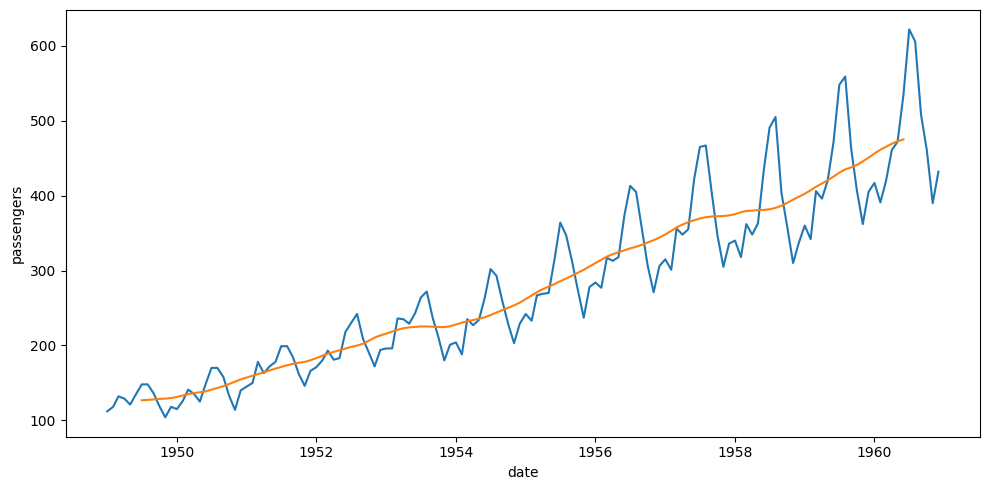

In [5]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Se confirma lo observado: una clara tendencia positiva a lo largo de los años.

#### Análisis de la estacionalidad

La estacionalidad se refiere a los patrones repetitivos en los datos. Para acceder a su información recurrimos al componente `seasonal` del resultado `decomposition`.

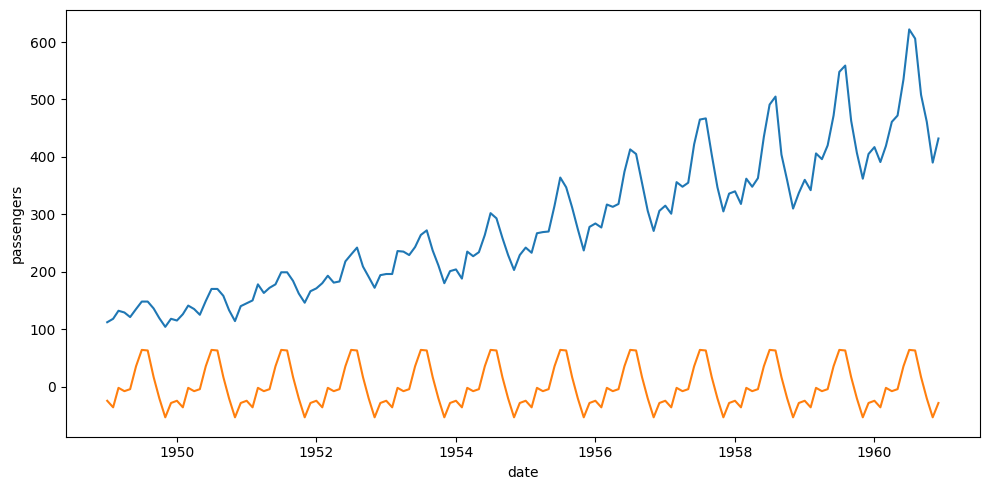

In [6]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Para evaluar la estacionalidad de la serie temporal podemos aplicar la llamada **Prueba de Dickey-Fuller** (*Dickey-Fuller test*), que es un contraste de hipótesis en el que la hipótesis nula es que la serie es estacionaria, y la alternativa, que es no estacionaria:

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Aquí podemos ver que el `p-value` es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

#### Análisis de la variabilidad

La variabilidad implica el estudio de los residuos: que es cómo fluctúan los datos una vez se ha estudiado la tendencia y la estacionalidad. Para acceder a su información recurrimos al componente `resid` del resultado `decomposition`.

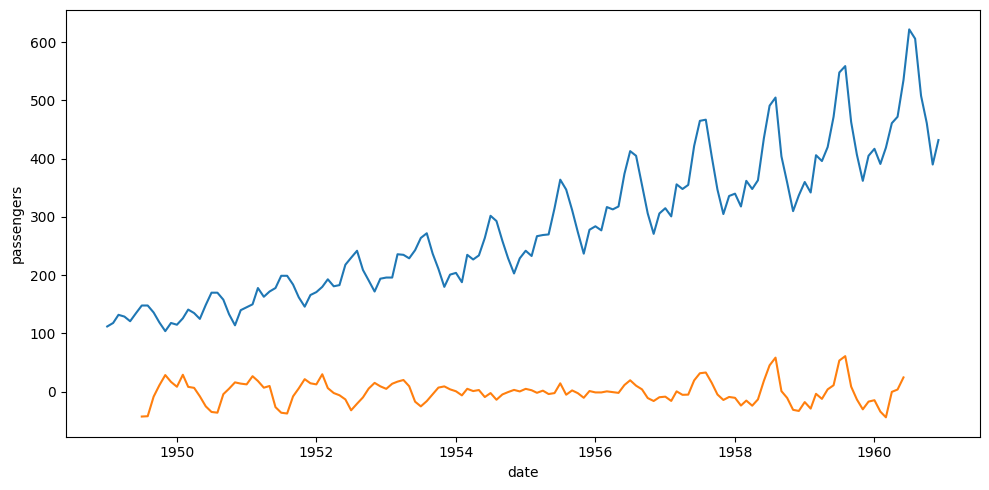

In [8]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Se confirma en parte lo observado, ya que la carga de residuos se hace más notable al inicio y al final del periodo estudiado.

#### Análisis de la autocorrelación

 La autocorrelación es la correlación de una serie de tiempo con una copia retrasada de sí misma. Este gráfico nos ayuda a ver si los valores en la serie de tiempo están correlacionados con los valores anteriores.

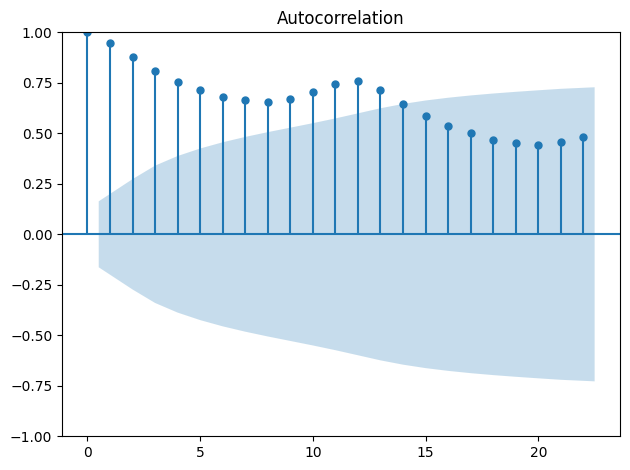

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye a lo largo del tiempo.

### Paso 3: Entrenamiento del modelo

Un modelo $ARIMA(p, d, q)$ consta de tres hiperparámetros:

- `p`: El orden del componente autorregresivo (AR).
- `d`: El grado de diferenciación necesario para hacer la serie de tiempo estacionaria.
- `q`: El orden del componente de media móvil (MA).

El estudio de estos hiperparámetros escapa nuestra función, ya que es un análisis puramente matemático-estadístico. Hoy en día existen herramientas que nos facilitan la vida estimando de forma interna los hiperparámetros más apropiados y generando el mejor modelo posible, como el paquete `pmdarima` y su función `auto_arima`. Lo único que tenemos que considerar es que para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria, y como en el caso de esta serie no lo es, debemos transformarla:

In [10]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Ahora la serie si que lo es, y podemos aplicar el método ARIMA automático:

In [11]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1033.479, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1022.316, Time=0.21 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1022.905, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1022.343, Time=0.10 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1021.137, Time=0.52 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1022.411, Time=0.48 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1034.068, Time=0.63 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1023.008, Time=0.78 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1022.906, Time=0.65 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=1021.017, Time=0.34 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1022.315, Time=0.15 sec
 ARIMA(0,0,1)(2,1,1)[12] inte

Como podemos ver, la función hace una búsqueda en el espacio de soluciones posible para estimar los mejores parámetros. En este caso tendríamos un $ARIMA(0, 0, 1)$. El modelo que devuelve esta función es totalmente usable, como cualquier otro que hayamos visto, y su función `summary()` devuelve información estadística y sobre su rendimiento que tiene gran valor:

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Thu, 03 Aug 2023   AIC                           1019.179
Time:                                     16:31:22   BIC                           1030.680
Sample:                                 02-01-1949   HQIC                          1023.852
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.371      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Paso 3: Predicción del modelo

Una vez se ha entrenado el modelo, se puede utilizar para predecir a futuro (predeciremos los siguientes `10` meses)

In [13]:
forecast = model.predict(10)
forecast

1961-01-01    19.346932
1961-02-01   -24.244912
1961-03-01    36.280007
1961-04-01    36.323602
1961-05-01    14.329657
1961-06-01    57.816446
1961-07-01    89.458676
1961-08-01   -13.228998
1961-09-01   -96.797005
1961-10-01   -50.216336
Freq: MS, dtype: float64

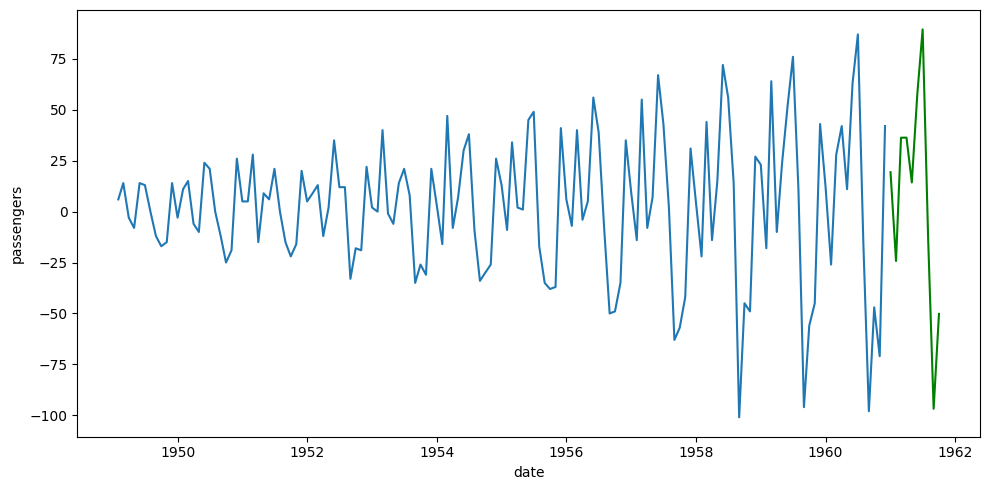

In [14]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

Ahora nuestro modelo es capaz de realizar predicciones futuras sobre nuestra serie estacionaria.